Installation of matplotlib, ast, and clarifai_grpc

In [1]:
# matplotlib and ast
!pip install matplotlib
!pip install ast
!pip install clarifai_grpc

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 2.4 MB/s eta 0:00:00


Importing the necessary libraries into the code and mounting the datasets using google drive.

In [2]:
# Libraries import
import pandas as pd
import ast
import math
import seaborn as sns
import matplotlib.pyplot as plt
import random
import csv
from clarifai_grpc.channel.clarifai_channel import ClarifaiChannel
from clarifai_grpc.grpc.api import resources_pb2, service_pb2, service_pb2_grpc
from clarifai_grpc.grpc.api.status import status_code_pb2
from google.colab import files
import re
from google.colab import drive
drive.mount('/content/drive')

# Load customer and restaurant data from CSV files in Google Drive
restaurant_data = pd.read_csv("/content/drive/MyDrive/restaruant_data.csv")
customer_data = pd.read_csv("/content/drive/MyDrive/user_data.csv")
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive
Mounted at /content/drive


**Food Recognition (Visual Dining Guide):** This segment introduces an innovative feature where users can upload an image of a dish, and the chatbot will attempt to recognize the dish using visual recognition technology. Once identified, the chatbot provides information on which restaurants serve the recognized dish, allowing users to easily find where they can enjoy that particular meal. This is especially useful for users who might have seen a dish on social media or elsewhere and want to try it but don't know its name or where to find it. The food recognition feature bridges the gap between visual craving and actual dining.



In [3]:
def get_restaurants_and_dishes(food, dishes):
    """
    Returns the restaurant's name, dish name, and its price if the food matches any dish in the dishes.
    """
    # Convert the dishes string to a dictionary
    dishes_dict = ast.literal_eval(dishes)

    # Iterate through the dishes to find a match with the given food
    for dish, price in dishes_dict.items():
        if re.search(food, dish, re.IGNORECASE) or re.search(dish, food, re.IGNORECASE):
            return dish, price
    return None, None

def recognize_food(restaurant_data, image_url=None):
    # If no image URL is provided, prompt the user to upload an image
    if image_url is None:
        uploaded = files.upload()
        if not uploaded:
            print("You didn't upload a photo")
            return None
        image_path = next(iter(uploaded.keys()))

        # Read the uploaded image
        with open(image_path, 'rb') as image_file:
            image_data = image_file.read()

        # Prepare the image data for the API call
        image_input = resources_pb2.Input(
            data=resources_pb2.Data(
                image=resources_pb2.Image(
                    base64=image_data
                )
            )
        )
    else:
        # Use the provided image URL for the API call
        image_input = resources_pb2.Input(
            data=resources_pb2.Data(
                image=resources_pb2.Image(
                    url=image_url
                )
            )
        )

    # authentication and model details
    PAT = '776997e95486408b86eb1ca97d841a9a'
    USER_ID = 'clarifai'
    APP_ID = 'main'
    GENERAL_MODEL_ID = 'general-image-recognition'
    GENERAL_MODEL_VERSION_ID = 'aa7f35c01e0642fda5cf400f543e7c40' # You may need to adjust this for the food model
    FOOD_MODEL_ID2 = 'food-item-v1-recognition'
    FOOD_MODEL_VERSION_ID2 = 'dfebc169854e429086aceb8368662641'
    FOOD_MODEL_ID = 'food-item-recognition'
    FOOD_MODEL_VERSION_ID = '1d5fd481e0cf4826aa72ec3ff049e044'

    # Create Clarifai channel and stub
    channel = ClarifaiChannel.get_grpc_channel()
    stub = service_pb2_grpc.V2Stub(channel)
    metadata = (('authorization', 'Key ' + PAT),)
    userDataObject = resources_pb2.UserAppIDSet(user_id=USER_ID, app_id=APP_ID)

    # Call the Clarifai API with the general model
    post_model_outputs_response = stub.PostModelOutputs(
        service_pb2.PostModelOutputsRequest(
            user_app_id=userDataObject,
            model_id=GENERAL_MODEL_ID,
            version_id=GENERAL_MODEL_VERSION_ID,
            inputs=[image_input]
        ),
        metadata=metadata
    )
    output = post_model_outputs_response.outputs[0]
    result = [(concept.name, concept.value) for concept in output.data.concepts]
    # List of common ingredients to check against
    ingredient_list = ['lettuce', 'cheese', 'bread', 'tomato', 'meat', 'ham', 'basil', 'sausage', 'ham',
                   'turkey', 'cucumber', 'bacon', 'chicken', 'mozzarella','cheddar', 'spinach',
                   'mushroom', 'gouda', 'salami', 'cereal', 'pepperoni', 'tomato', 'garlic', 'onion',
                   'eggplant', 'almond', 'olive', 'lemon', 'fish', 'raspberry', 'stuffing', 'eel',
                   'blueberry', 'nori', 'grape', 'jalapeno', 'salmon', 'seafood', 'ginger', 'avocado',
                   'tuna', 'trout', 'candy', 'pork', 'rice', 'corn', 'chili', 'beef', 'lamb\'s lettuce','watercress',
                   'carrot', 'endive', 'romaine', 'arugula', 'cherry tomato', 'cress', 'artichoke', 'broccoli',
                   'butter', 'honey', 'nut', 'dough', 'chocolate', 'citrus', 'banana', 'prawn', 'shrimp',
                   'shellfish', 'potato', 'scampi', 'coconut', 'crab', 'doughnut', 'lobster', 'egg', 'beans', 'rosemary',
                   'asparagus', 'zucchini', 'squash', 'pumpkin', 'blue cheese', 'cauliflower', 'pastry']
    # Check if the image contains food or ingredients from the list
    if any(concept.name.lower() in ['food'] + ingredient_list for concept in output.data.concepts):
        post_model_outputs_response = stub.PostModelOutputs(
            service_pb2.PostModelOutputsRequest(
                user_app_id=userDataObject,
                model_id=FOOD_MODEL_ID,
                version_id=FOOD_MODEL_VERSION_ID,
                inputs=[image_input]
            ),
            metadata=metadata
        )
        # Extract recognized foods that are not common ingredients
        recognized_foods = [concept.name for concept in post_model_outputs_response.outputs[0].data.concepts if concept.name.lower() not in ingredient_list]
        # Display the top 3 recognized foods and corresponding restaurants that serve them
        for food in recognized_foods[:3]:
            print(f"The dish might be: {food}")
            restaurants_serving_food = restaurant_data[restaurant_data['Budget Range Dishes'].apply(lambda x: get_restaurants_and_dishes(food, x)[0] is not None)]

            if not restaurants_serving_food.empty:
                print("Restaurants that serve this dish:")
                for _, row in restaurants_serving_food.iterrows():
                    dish_name, price = get_restaurants_and_dishes(food, row['Budget Range Dishes'])
                    print(f"- {row['Name']} (Dish: {dish_name}, Price: {price})")
            else:
                print("No store contains this dish.")
            print("------")
    else:
        # Display the top 4 detected elements if no food is recognized
        detected_elements = [name for name, _ in result[0:4]]
        print(f"The image you uploaded contains elements {', '.join(detected_elements)}. No food detected.")

**Recommendation (Meal Planning):** In this section, Chatbot will ask a series of questions including such as budget, occasion, preferred waiting time, and so on. Base on this information, it will filter out the qulified restaurants with qualified dished as recommendations for customers. Also, it can recommend several meals at a time for users to do meal planning.


In [4]:
# this function will be called within "meal_recommendation()" function while the customer wants recommendations for several meals.
def meal_list(budget:int, occasion:str, notInclude:str, time:int, rating:float):

  # Extract the upper bound from the 'Budget' column
  restaurant_data['UpperBound'] = restaurant_data['Budget Range'].str.extract(r'\$(\d+) - \$\d+', expand=False)

  # Convert the 'UpperBound' column to an integer data type
  restaurant_data['UpperBound'] = restaurant_data['UpperBound'].astype(int)

  # Filter restaurants based on the user inputs
  qualifiedRestaurant = restaurant_data[(restaurant_data["UpperBound"] <= budget) &
                                        (restaurant_data["Suitable Occasions"].str.contains(occasion)) &
                                        (restaurant_data["Type of Cuisine"] != notInclude) &
                                        (restaurant_data["Average Waiting Time (min)"] <= time) &
                                        (restaurant_data["Rating"] >= rating)]

  # Make recommendations based on the number of meals required
  filter_list = []
  for index, row in qualifiedRestaurant.iterrows():
      restaurant = row["Name"]
      dishes = ast.literal_eval(row['Budget Range Dishes'])
      for dish, price in dishes.items():
          one_meal = ["Restaurant:" + str(restaurant), "Dish: " + str(dish) + "$" + str(price)]
          filter_list.append(one_meal)

  return filter_list


# this function is to recommend a meal when customer choose "I don’t know what I want to eat”.
def meal_recommendation():

  # greeting first
  print("Welcome to your meal recommendation! Let's start with some questions.")

  # get user input for basic parameters
  budget = int(input("What's your maximum budget: "))
  occasion = input("""What's your occasion, You can choose from the following list
                      [Breakfast, Lunch, Dinner, Celebration, Casual, Brunch, Family]
                                   (please enter one word only): """).capitalize()
  notInclude = input("""Is there anything you know you do not want to eat today, You can choose from the following list
                     [American, Japanese, Italian, Indian, French, Thai, Mexican, Fusion, Greek, Asian, Spanish, Chinese]
                                               (please enter one type of cuisine): """).capitalize()
  waiting_time = int(input("What's your maximum expected time for waiting in minutes (please enter a number): "))
  rating = float(input("What's your minimum expected rating of the restaurant (out of 5): "))

  # ask if the customer wants a meal plan
  num_meals = int(input("How many meals you want for recommendations: "))

  # fetch all possible recommendations
  all_recommendations = meal_list(budget, occasion, notInclude, waiting_time, rating)

  if len(all_recommendations) < num_meals:
    print("Sorry, we cannot find enough meals to match your criteria.")
    return

  while True:
    # choose a random subset of meals
    recommendations = random.sample(all_recommendations, num_meals)

    print(f"I would recommend {recommendations} for your {num_meals} meals plan.")
    response = input("Are you happy with my recommendation (yes/no): ").lower()

    # ask for customers' satisfaction
    if response == "yes":
      print("Great, your meal is added to your cart!")
      break
    else:
      print("Alright! Let's try another recommendation.")

**Surprise food:** Within this segment, the chatbot caters to users who are open to culinary surprises. The chatbot comes to the rescue by recommending a random dish from its database of restaurants. By eliminating the need to scan through lengthy menus, this feature offers an exciting and effortless way to break the routine and embrace spontaneity in dining.


In [5]:
#first we need to read the data containg names of restaurants and dishes they serve
def read_restaurant_data(filename):
    restaurant_dict = {}
    with open(filename, 'r') as file:
        csv_reader = csv.DictReader(file)
        for row in csv_reader:
            restaurant_name = row['Name']
            budget_range_dishes = eval(row['Budget Range Dishes'])
            restaurant_dict[restaurant_name] = budget_range_dishes
    return restaurant_dict

partial_restaurant_data = read_restaurant_data('/content/drive/MyDrive/restaruant_data.csv')

#function to get user input yes/no
def get_user_input(prompt):
    while True:
        user_input = input(prompt).lower()
        if user_input == "yes" or user_input == "no":
            return user_input
        else:
            print("Invalid input. Please enter 'yes' or 'no'.")
#function to select a random dish and restuarant
def select_random_dish(partial_restaurant_data):
    selected_restaurant = random.choice(list(partial_restaurant_data.keys()))
    selected_dish = random.choice(list(partial_restaurant_data[selected_restaurant].keys()))
    selected_price = partial_restaurant_data[selected_restaurant][selected_dish]
    return selected_dish, selected_restaurant, selected_price

#main function handling the input of user and giving a recommendation
def surprise_dish():
    conversation_active = True
    while conversation_active:
        q1 = get_user_input("Are you interested in getting surprised today, yes/no? \n").lower()
        if q1 == "yes":
              selected_dish, selected_restaurant, selected_price = select_random_dish(partial_restaurant_data)
              q3 = get_user_input(f"Great. I have selected {selected_dish} at {selected_restaurant} for ${selected_price}. Are you happy with this selection?\n")
              if q3 == "yes":
                  print("Great. The order has been added to your cart. Click on the checkout button to complete your purchase.")
                  conversation_active = False
              elif q3 == "no":
                  while True:
                      selected_dish, selected_restaurant, selected_price = select_random_dish(partial_restaurant_data)
                      q4 = get_user_input(f"I have selected {selected_dish} at {selected_restaurant} for ${selected_price} as an alternative. Are you happy with this selection?\n")
                      if q4 == "yes":
                          print("Great. The order has been added to your cart. Click on the checkout button to complete your purchase.")
                          conversation_active = False
                          break
                      elif q4 == "no":
                          continue
                      else:
                          print("Invalid input. Please enter 'yes' or 'no'.")
              else:
                  print("Invalid input. Please enter 'yes' or 'no'.")
        elif q1 == "no":
            print("Thank you! Have a nice day.")
            conversation_active = False

**Eats Wrapped:**
This section is where the EatsWrapped aspect of the chatbot is created. This begins by creating the visualization format that is going to be used to create the EatsWrapped visualizations using the customer dataset above. Next, the EatsWrapped function is created the input the proper parameters to calculate various data scenarios and create visualizations when needed.

In [6]:
# Eats Wrapped
# Section based on "Check my EatsWrapped in the chatbot interaction below"
#Generate the introduction message to diplay to the user
intro_msg = "Let's check your EatsWrapped data! I'm here to show you your food delivery stats."
options_msg = "You can ask me about your order history, your most eaten dishes, the number of dishes eaten, your app usage time, or the number of orders you've placed."

def generate_visualization(data, x_label, y_label, title):
    # Set style and context
    sns.set_style("whitegrid")
    sns.set_context("talk")

    # Create a color palette based on bar values
    color_palette = sns.light_palette("blue", n_colors=len(data))

    # Create the plot
    plt.figure(figsize=(12, 9))
    ax = sns.barplot(x=data.index, y=data.values, palette=color_palette, edgecolor="black")

    # Add annotations to bars
    for index, value in enumerate(data.values):
        ax.text(index, value, f'{value}', color='black', ha="center", va="bottom")

    # Remove unnecessary spines
    sns.despine(left=True, bottom=True)

    # Set labels, title, and x-ticks
    plt.xlabel(x_label, fontsize=15)
    plt.ylabel(y_label, fontsize=15)
    plt.title(title, fontsize=18)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

def check_eats_wrapped(user_input1, customer_name, customer_data):
    # Filter the data first to avoid repetitive DataFrame operations
    user_data = customer_data[customer_data['Name'] == customer_name]

    # Check if user data exists
    if user_data.empty:
        return f"No data found for user: {customer_name}"

    user_data = user_data.iloc[0]

    # For "order history"
    if "order history" in user_input1:
        order_dates = ast.literal_eval(user_data["History Orders - Date/Time"])
        restaurants = ast.literal_eval(user_data["Restaurant"])

        # Combine restaurants and order dates
        orders_info = list(zip(restaurants, order_dates))

        # Generate the response message
        order_messages = [f"You ordered from {restaurant} on {order_date}" for restaurant, order_date in orders_info]
        return "\n".join(order_messages)

    # For "eaten dishes" - using generate_visualization function now
    elif "eaten dishes" in user_input1:
        individual_dishes = [item for sublist in ast.literal_eval(user_data['Dishes']) for item in sublist]
        dish_counts = pd.Series(individual_dishes).value_counts()
        top_dishes = dish_counts.head(2)
        generate_visualization(top_dishes, "Dishes", "Count", f'Top 2 Most Eaten Dishes for {customer_name}')
        return f"Here are the top 2 most eaten dishes for {customer_name}!"

    # For "app usage time"
    elif "app usage time" in user_input1:
        app_usage_time = user_data["Browsing Time before Confirming (min)"]
        return f"You've spent a total of {app_usage_time} minutes browsing the app this year, {customer_name}."

    # For "number of orders"
    elif "number of orders" in user_input1:
        total_orders = len(ast.literal_eval(user_data["History Orders - Date/Time"]))
        return f"You've placed {total_orders} orders this year, {customer_name}."

    else:
        return "I'm sorry, I didn't understand that."


*EatBot* Interaction

This is the function the calls the main chatbot (EatBot), which the user interacts with.
The chatbot calls each above function when prompted by the user.

What is your name? Amelia Johnson
Hi, how can I help you today? 
Would you like to choose a service from below? (please enter a number)
                                      1. Searching for food
                                      2. I don't know what to eat today
                                      3. Surprise meal bag plz
                                      4. Check my EatsWrapped!
                                      5. Quit
You: 1
Input 1 for online image detection or 2 to upload your own photo2


Saving img.jpeg to img.jpeg
The dish might be: pizza
Restaurants that serve this dish:
- Mama's Kitchen (Dish: Pizza, Price: 9.5)
- Fusion Flavors (Dish: Curry Pizza, Price: 16.5)
- Napoli Pizzeria (Dish: Margherita Pizza, Price: 8.0)
- Napoli Ristorante (Dish: Margherita Pizza, Price: 11.5)
- Napoli Trattoria (Dish: Margherita Pizza, Price: 12.0)
- Pizzeria Paradiso (Dish: Margherita Pizza, Price: 20.0)
- Napoli Ristorante (Dish: Margherita Pizza, Price: 11.5)
- Pizzeria Bella (Dish: Margherita Pizza, Price: 16.5)
- Napoli Ristorante (Dish: Margherita Pizza, Price: 12.5)
- Pizzeria Bella (Dish: Margherita Pizza, Price: 19.0)
- Napoli Ristorante (Dish: Margherita Pizza, Price: 8.5)
- Pizzeria Bella (Dish: Margherita Pizza, Price: 13.0)
- Napoli Ristorante (Dish: Margherita Pizza, Price: 10.0)
- Pizzeria Bella (Dish: Margherita Pizza, Price: 15.5)
------
The dish might be: pie
No store contains this dish.
------
The dish might be: sausage roll
No store contains this dish.
------
Hi, how

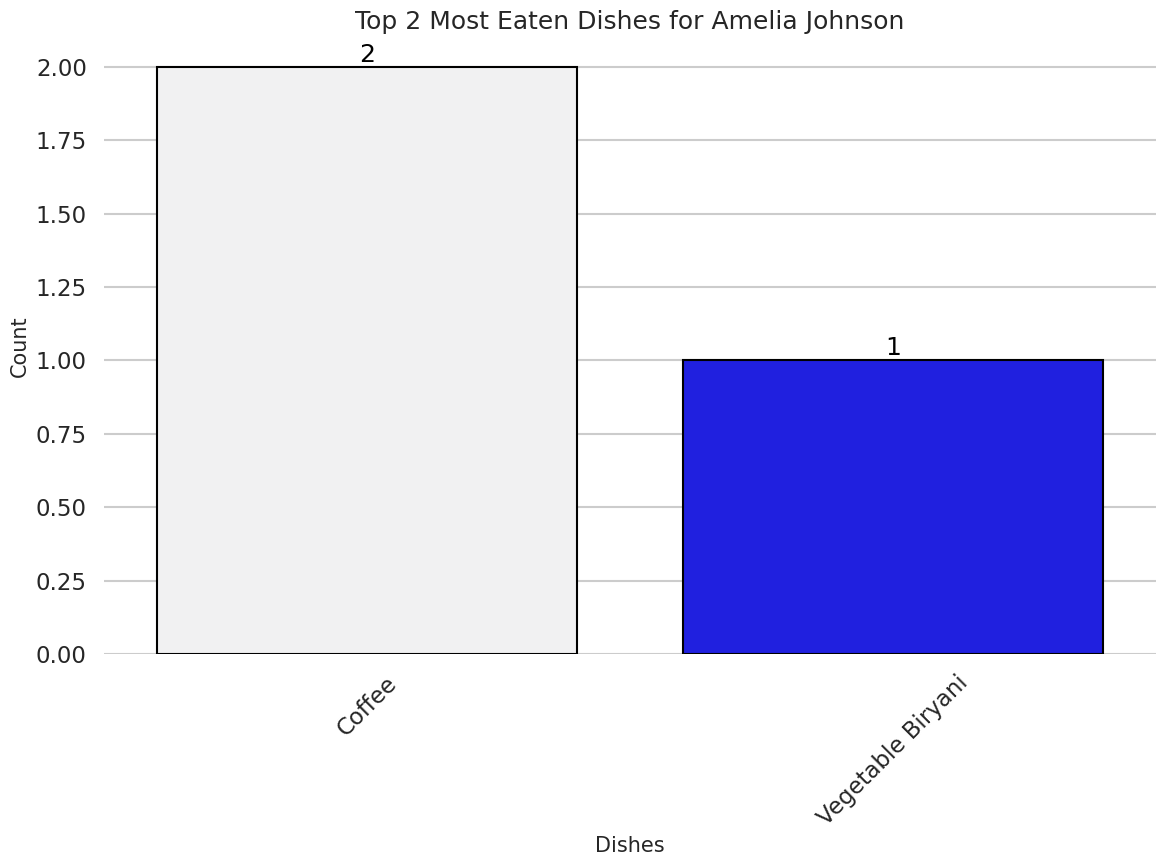

Here are the top 2 most eaten dishes for Amelia Johnson!
What would you like to see? Please enter one of the following:
                            Order history
                            Number of dishes
                            Eaten dishes
                            App usage time
                            Number of orders
                            Exit (to go back)
You: app usage time
You've spent a total of 63 minutes browsing the app this year, Amelia Johnson.
What would you like to see? Please enter one of the following:
                            Order history
                            Number of dishes
                            Eaten dishes
                            App usage time
                            Number of orders
                            Exit (to go back)
You: exit
Hi, how can I help you today? 
Would you like to choose a service from below? (please enter a number)
                                      1. Searching for food
                      

In [9]:
def main():
  # this will be a infinite loop until the customer choose to quit
  customer_name = input("What is your name? ")
  while True:
    # greating and let user choose from our four scenarios
    print("Hi, how can I help you today? ")
    print("""Would you like to choose a service from below? (please enter a number)
                                      1. Searching for food
                                      2. I don't know what to eat today
                                      3. Surprise meal bag plz
                                      4. Check my EatsWrapped!
                                      5. Quit""")
    user_input = int(input("You: "))

    # call respective functions when users made choices or say bye if none is choosing
    if user_input == 1:
      # call searching (image recognizing) function
      search = int(input('Input 1 for online image detection or 2 to upload your own photo'))
      if (search == 1):
        url = str(input('Input the url link for the image.'))
        recognize_food(restaurant_data,url)
      else:
        recognize_food(restaurant_data,None)
    elif user_input == 2:
      # call recommendation function
      meal_recommendation()
    elif user_input == 3:
      # call suprise meal function
      surprise_dish()
    elif user_input == 4:
      # call EatsWrapped function
        print(intro_msg)
        print(options_msg)

        # EatsWrapped inner loop
        while True:
          print("""What would you like to see? Please enter one of the following:
                            Order history
                            Number of dishes
                            Eaten dishes
                            App usage time
                            Number of orders
                            Exit (to go back)""")
          user_input1 = input("You: ").lower()

          if user_input1 == "exit":
                    break

          response = check_eats_wrapped(user_input1, customer_name, customer_data)
          print(response)
    elif user_input == 5:
      # exit the loop
      print("Goodbye and have a nice day!")
      break
    else:
      print("Invalid input, please try again!")

if __name__ == "__main__":
  main()
